In [1]:
# Phishing challenge (Machile learning/Data Science)
# Owner Amitabh Bhattacharya

# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import re

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score


In [2]:
# Loading the dataset
train_val = pd.read_csv("phishing_dataset.csv")
train_val = train_val.iloc[:,1:]
train_val.head()


,create_age(months),expiry_age(months),update_age(days),URL,Label
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1
1,212,16,663,http://www.coffeespecialties.com/...,0
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1
3,198,6,186,http://atomicsoda.com/manutd...,0
4,240,24,1684,http://bostoncoffeecake.com/...,0


In [3]:
# Dataset information
print(train_val.info())

# Dataset description
print(train_val.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 5 columns):
create_age(months)    4799 non-null int64
expiry_age(months)    4799 non-null int64
update_age(days)      4799 non-null int64
URL                   4799 non-null object
Label                 4799 non-null int64
dtypes: int64(4), object(1)
memory usage: 187.5+ KB
None
       create_age(months)  expiry_age(months)  update_age(days)        Label
count         4799.000000         4799.000000       4799.000000  4799.000000
mean            91.288810           12.264430        272.264638     0.532403
std             92.868921           20.033764        618.276458     0.499001
min             -1.000000          -78.000000       -115.000000     0.000000
25%             -1.000000           -1.000000         -1.000000     0.000000
50%             56.000000            7.000000         91.000000     1.000000
75%            188.000000           12.000000        292.500000     1.000000
max       

In [4]:
# Fields update_age(days) & expiry_age(months) has outliers
# train_val["update_age(days)"].value_counts().sort_index()
train_val.loc[train_val["update_age(days)"] < -1, "update_age(days)"] = -1

# train_val["expiry_age(months)"].value_counts().sort_index()
train_val.loc[train_val["expiry_age(months)"] < -1, "expiry_age(months)"] = -1


In [5]:
# Getting rid of starting substring http:// or https:// and ending ... in URL string
train_val["URL"] = train_val["URL"].str.split("://").str[1]
train_val["URL"] = train_val["URL"].str[:-3]


In [6]:
# Feature engineering (URL processing)

# URL length
train_val["url_length"] = train_val["URL"].str.len()

# Total number of digits in the URL
regex_1 = re.compile(r"\d")
train_val["digit_count"] = train_val["URL"].apply(lambda x: len(regex_1.findall(x)))

# Total number of sub-domains present in the URL
train_val["full_domain"] = train_val["URL"].str.split("/").str[0]
regex_2 = re.compile(r"\.")
train_val["sub_domain_count"] = train_val["full_domain"].apply(lambda x: len(regex_2.findall(x)) - 1)
train_val.drop(["full_domain"], axis = 1, inplace = True)

# Presence of characters like ?, %, digits        
train_val["strange_char_presence"] = train_val["URL"].apply(lambda x: int(bool(re.search(r"[?]", x))))
train_val["strange_char_presence"] = train_val["strange_char_presence"] + train_val["URL"].apply(lambda x: int(bool(re.search(r"[%]", x))))
train_val["strange_char_presence"] = train_val["strange_char_presence"] + train_val["URL"].apply(lambda x: int(bool(re.search(r"\d+[a-zA-Z]+\d+", x))))
train_val["strange_char_presence"] = train_val["strange_char_presence"].apply(lambda x: 1 if x > 0 else 0)

# The below output shows that 2.93 % results are False negative towards the above engineered feature 
# which is a good score.
fn = 100*len(train_val[(train_val.strange_char_presence == 1) & (train_val.Label == 0)]) \
/len(train_val[train_val.strange_char_presence == 1])

print("False negative percent value for 'strange_char_presence': ", fn)

print("\n")
corr_1 = train_val[["Label", "strange_char_presence"]].corr()
print(corr_1)


False negative percent value for 'strange_char_presence':  2.937720329024677


                          Label  strange_char_presence
Label                  1.000000               0.407767
strange_char_presence  0.407767               1.000000


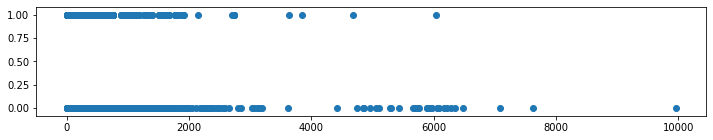

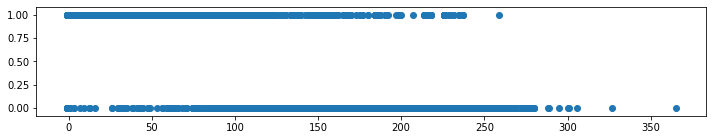

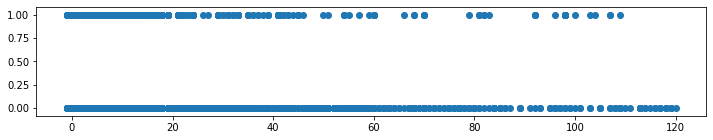

In [7]:
# Figuring pattern in provide features when compared with Label
# train_val["update_age(days)"].value_counts().sort_index()

plt.figure(figsize=(12,2))
print(plt.scatter(train_val["update_age(days)"], train_val["Label"]), "\n")
plt.show()

plt.figure(figsize=(12,2))
print(plt.scatter(train_val["create_age(months)"], train_val["Label"]), "\n")
plt.show()

plt.figure(figsize=(12,2))
print(plt.scatter(train_val["expiry_age(months)"], train_val["Label"]), "\n")
plt.show()


In [8]:
# Binarizing the fields update_age(days), create_age(months), expiry_age(months)
as1 = train_val["update_age(days)"].mean()
train_val["update_age_lt_mean"] = train_val["update_age(days)"].apply(lambda x: 1 if x <= as1 else 0)

as2 = train_val["create_age(months)"].mean()
train_val["create_age_lt_mean"] = train_val["create_age(months)"].apply(lambda x: 1 if x <= as2 else 0)


In [9]:
train_val.head()

,create_age(months),expiry_age(months),update_age(days),URL,Label,url_length,digit_count,sub_domain_count,strange_char_presence,update_age_lt_mean,create_age_lt_mean
0,-1,-1,-1,account-google-com.ngate.my/c44cca401760e0c1e1...,1,60,21,1,1,1,1
1,212,16,663,www.coffeespecialties.com/,0,26,0,1,0,0,0
2,-1,-1,-1,black.pk/wp-content/2013/04/bp.postale/9630609...,1,63,21,0,1,1,1
3,198,6,186,atomicsoda.com/manutd,0,21,0,0,0,1,0
4,240,24,1684,bostoncoffeecake.com/,0,21,0,0,0,0,0


In [11]:
# Modelling/Training RandomForestClassifier model

model_cols = ["url_length", "digit_count", "sub_domain_count", "create_age_lt_mean", "update_age_lt_mean", \
              "strange_char_presence", "create_age(months)", "update_age(days)", "expiry_age(months)"]

rfc = RandomForestClassifier(n_estimators = 50, max_depth = 10, n_jobs = -1)
rfc.fit(train_val[model_cols], train_val["Label"])

model_file = ("model_rfc.sav")
pickle.dump(rfc, open(model_file, 'wb'))

loaded_rfc = pickle.load(open(model_file, 'rb'))

f1_mean_rfc = np.mean(cross_val_score(loaded_rfc, train_val[model_cols], train_val["Label"], scoring = "f1", cv = 5))
print ("F1 score for the validation dataset is: ", round(f1_mean_rfc, 3))


F1 score for the validation dataset is:  0.932


In [12]:
# Test dataset preparation function. 
# This function takes a csv file as input. The input csv format should be same like phishing_dataset.csv
# The output is a dataframe containing all features required for the testing including engineered features as well
# as the y label. Just extract the y label from the output dataframe returened from the function and apply for prediction.

def test_prep(test):
    # Removing the first column
    df = test.copy()
    df = df.iloc[:,1:]
    
    # Fields update_age(days) & expiry_age(months) has outliers
    df.loc[df["update_age(days)"] < -1, "update_age(days)"] = -1
    df.loc[df["expiry_age(months)"] < -1, "expiry_age(months)"] = -1
    
    df["URL"] = df["URL"].str.split("://").str[1]
    df["URL"] = df["URL"].str[:-3]
    
    # URL processing...
    # URL length
    df["url_length"] = df["URL"].str.len()
    df["digit_count"] = df["URL"].apply(lambda x: len(regex_1.findall(x)))
    
    # Total number of sub-domains present in the URL
    df["full_domain"] = df["URL"].str.split("/").str[0]
    df["sub_domain_count"] = df["full_domain"].apply(lambda x: len(regex_2.findall(x)) - 1)
    df.drop(["full_domain"], axis = 1, inplace = True)
    
    df["strange_char_presence"] = df["URL"].apply(lambda x: int(bool(re.search(r"[?]", x))))
    df["strange_char_presence"] = df["strange_char_presence"] + df["URL"].apply(lambda x: int(bool(re.search(r"[%]", x))))
    df["strange_char_presence"] = df["strange_char_presence"] + df["URL"].apply(lambda x: int(bool(re.search(r"\d+[a-zA-Z]+\d+", x))))
    df["strange_char_presence"] = df["strange_char_presence"].apply(lambda x: 1 if x > 0 else 0)

    # Binarizing the fields update_age(days), create_age(months), expiry_age(months)
    as1 = df["update_age(days)"].mean()
    df["update_age_lt_mean"] = df["update_age(days)"].apply(lambda x: 1 if x <= as1 else 0)
    as2 = df["create_age(months)"].mean()
    df["create_age_lt_mean"] = df["create_age(months)"].apply(lambda x: 1 if x <= as2 else 0)
        
    X_test = df[model_cols]
    y_test = df["Label"]
    
    df = pd.concat([X_test, y_test], axis = 1)
        
    return df
    

In [13]:
# Test prediction and scores

test = pd.read_csv("Test.csv")  # Change the Test.csv file name here with appropriate name
test_data = test_prep(test)
y_predict = loaded_rfc.predict(test_data[model_cols])

# F1_score
score_test = f1_score(test_data["Label"], y_predict)
print("F1 score for the test dataset is: ", round(score_test, 3))


F1 score for the test dataset is:  0.957
